In [1]:
#pip install timm

In [50]:
import torch
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from transformers import DetrImageProcessor, DetrForObjectDetection
import random

In [51]:
# Load the pre-trained DETR model and processor
model_name = "facebook/detr-resnet-50"
processor = DetrImageProcessor.from_pretrained(model_name)
model = DetrForObjectDetection.from_pretrained(model_name)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
# Load and preprocess the image
image_path = "Restaurant.jpg"
image = Image.open(image_path)
inputs = processor(images=image, return_tensors="pt", size=(800, 800), size_format="longest_edge")

In [53]:
# Make predictions
outputs = model(**inputs)
detections = processor.post_process_object_detection(outputs)

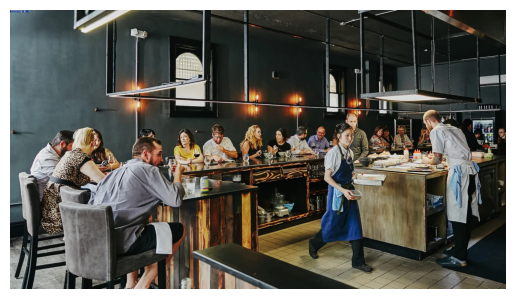

Summary: 6 chairs, 17 cups, 20 persons, 1 cell phone, 2 dining tables, 2 bowls


In [55]:
# Filter detections based on the threshold
threshold = 0.5
for detection in detections:
    selected_indices = detection["scores"] > threshold

    # Display the filtered predictions
    labels = detection["labels"][selected_indices].cpu().numpy()
    scores = detection["scores"][selected_indices].detach().cpu().numpy()
    boxes = detection["boxes"][selected_indices].detach().cpu().numpy()

    # Assign unique colors to each category
    category_colors = {label: tuple(int(255 * x) for x in color) for label, color in
                       zip(labels, [(random.random(), random.random(), random.random()) for _ in range(len(labels))])}

    # Visualize the bounding boxes on the image with colored boxes
    img_with_boxes = image.copy()
    draw = ImageDraw.Draw(img_with_boxes)

    for box, label, score in zip(boxes, labels, scores):
        box = [round(coord, 2) for coord in box]
        category_color = category_colors[label.item()]
        draw.rectangle(box, outline=category_color, width=3)
        draw.text((box[0], box[1]), f"{model.config.id2label[label.item()]}: {score:.2f}", fill=category_color)

    plt.imshow(img_with_boxes)
    plt.axis("off")
    plt.show()

    # Get the count of each type of object
    label_counts = {}
    for label, score in zip(labels, scores):
        label_name = model.config.id2label.get(label.item(), "Unknown")
        if label_name not in label_counts:
            label_counts[label_name] = 1
        else:
            label_counts[label_name] += 1

    # Display the count of each type of object
    summary = ""
    for label, count in label_counts.items():
        summary += f"{count} {label}{'s' if count > 1 else ''}, "
    summary = summary.rstrip(", ")
    print("Summary:", summary)